In [18]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import numpy as np
from sklearn.preprocessing import label_binarize
from wordcloud import WordCloud

In [19]:
df = pd.read_csv('/content/email.csv')
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [20]:
# обработка странного значения

print(df['Category'].value_counts())

df = df[(df['Category'] == 'ham') | (df['Category'] == 'spam')]

df['Category'].value_counts()

Category
ham               4825
spam               747
{"mode":"full"       1
Name: count, dtype: int64


,count
Category,
ham,4825
spam,747


In [21]:
df.isnull().sum() # проверка пропусков

,0
Category,0
Message,0


In [22]:
print(df.shape[0])

df = df.drop_duplicates() # удаление дубликатов

df.shape[0] # удаление дубликатов

5572


5157

In [23]:
df['Category'] = np.where(df['Category'] == 'spam', 1, 0) # обработка таргета
df['Category'].head()

,Category
0,0
1,0
2,1
3,0
4,0


In [24]:
X = df['Message']
y = df['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(max_features=3000)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

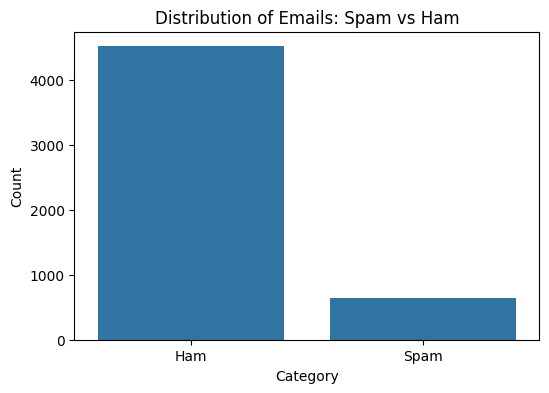

In [25]:
plt.figure(figsize=(6, 4))
sns.countplot(x='Category', data=df)
plt.title('Distribution of Emails: Spam vs Ham')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Ham', 'Spam'])
plt.show()

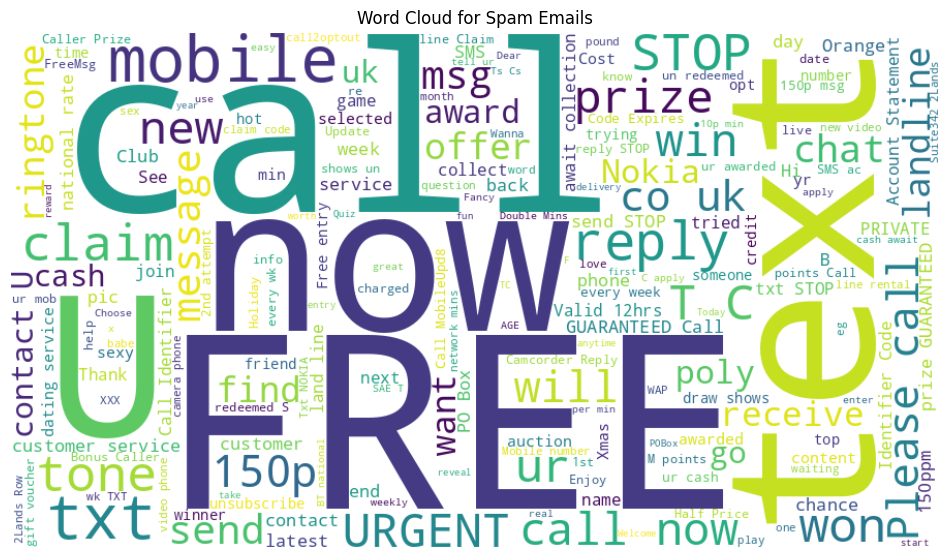

In [26]:
spam_words = ' '.join(list(df[df['Category'] == 1]['Message']))
spam_wordcloud = WordCloud(width=900, height=500, background_color='white').generate(spam_words)

plt.figure(figsize=(12, 8))
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Spam Emails')
plt.axis('off')
plt.show()

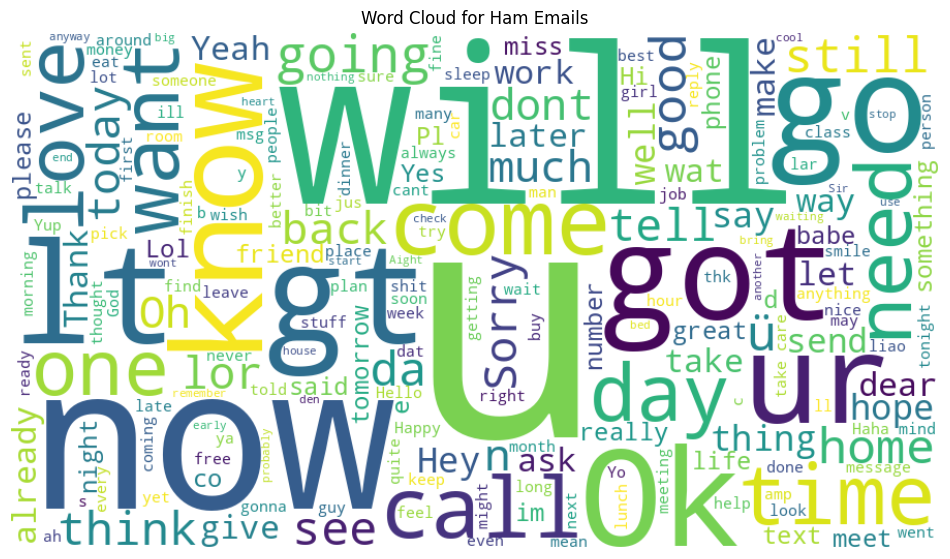

In [27]:
ham_words = ' '.join(list(df[df['Category'] == 0]['Message']))
ham_wordcloud = WordCloud(width=900, height=500, background_color='white').generate(ham_words)

plt.figure(figsize=(12, 8))
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Ham Emails')
plt.axis('off')
plt.show()

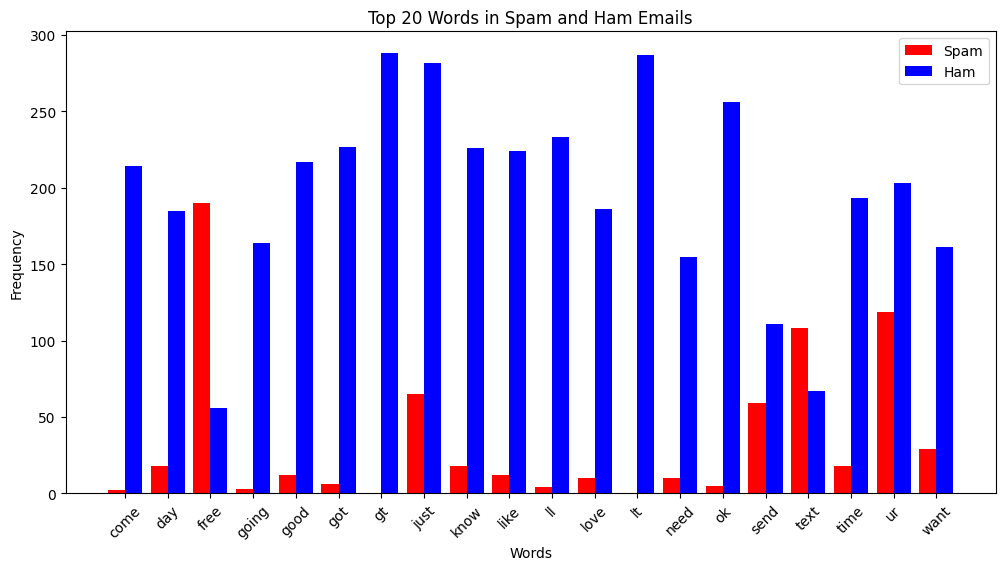

In [28]:
vectorizer = CountVectorizer(max_features=20, stop_words='english')
X_counts = vectorizer.fit_transform(df['Message'])

spam_df = df[df['Category'] == 1]
ham_df = df[df['Category'] == 0]

spam_counts = vectorizer.transform(spam_df['Message']).toarray().sum(axis=0)
ham_counts = vectorizer.transform(ham_df['Message']).toarray().sum(axis=0)

words = vectorizer.get_feature_names_out()
x = np.arange(len(words))

plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, spam_counts, width=0.4, label='Spam', color='red')
plt.bar(x + 0.2, ham_counts, width=0.4, label='Ham', color='blue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Words in Spam and Ham Emails')
plt.xticks(ticks=x, labels=words, rotation=45)
plt.legend()
plt.show()

In [29]:
xgb_model = XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train_tfidf, y_train)
xgb_pred = xgb_model.predict(X_test_tfidf)

XGBoost Classifier:
Accuracy: 0.9786821705426356
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       896
           1       0.95      0.89      0.92       136

    accuracy                           0.98      1032
   macro avg       0.96      0.94      0.95      1032
weighted avg       0.98      0.98      0.98      1032

Confusion Matrix:


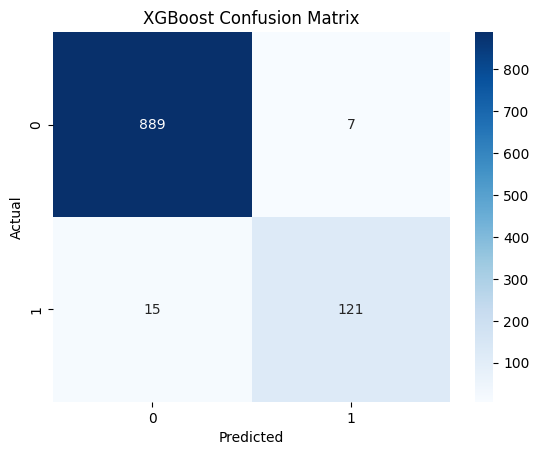

In [30]:
print("XGBoost Classifier:")
print(f"Accuracy: {accuracy_score(y_test, xgb_pred)}")
print("Classification Report:")
print(classification_report(y_test, xgb_pred))
print("Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, xgb_pred), annot=True, fmt='d', cmap='Blues')
plt.title('XGBoost Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

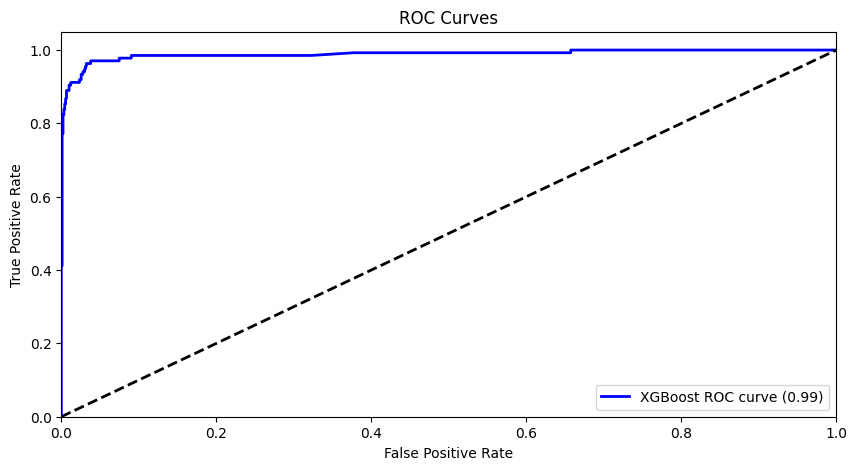

In [32]:
n_classes = len(np.unique(y_test))
if n_classes == 2:
    y_test_bin = label_binarize(y_test, classes=[0, 1])

xgb_scores = xgb_model.predict_proba(X_test_tfidf)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_bin, xgb_scores)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)


plt.figure(figsize=(10, 5))

plt.plot(fpr_xgb, tpr_xgb, color='blue', lw=2, label=f'XGBoost ROC curve ({roc_auc_xgb:0.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

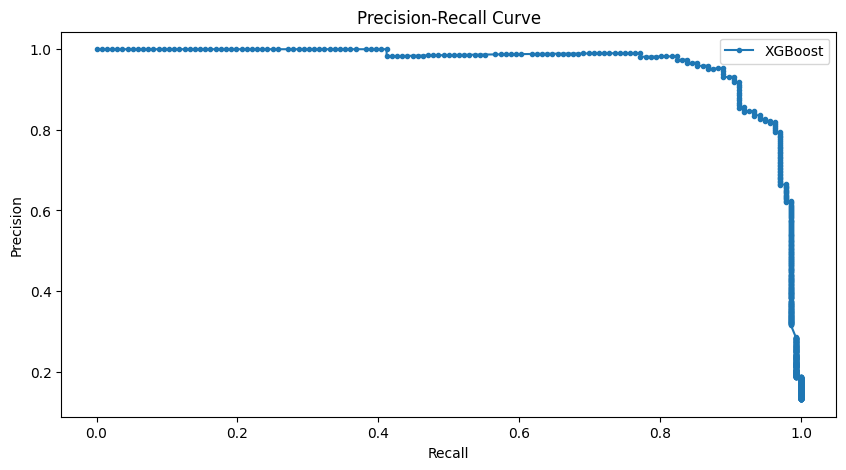

In [33]:
xgb_prob = xgb_model.predict_proba(X_test_tfidf)[:, 1]
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, xgb_prob)
plt.figure(figsize=(10, 5))
plt.plot(recall_xgb, precision_xgb, marker='.', label='XGBoost')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.show()